# Immune Score

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

## Reading Nhanes Data

In [2]:
dfAll = pd.read_csv('./data/nhanes_all.csv')

In [3]:
dfAll['AGE'] = dfAll['AGE']/12

In [4]:
dfN = pd.read_csv('./data/Unhealthy.csv')
dfN2 = pd.read_csv('./data/HealthySubjects.csv')
dfN = pd.concat([dfN,dfN2],ignore_index=True)

And we will remove all data points younger than 18.

In [5]:
dfN = dfN[dfN["AGE"]>= 18]
dfAll = dfAll[dfAll["AGE"]>= 18]

Data set dfAll does not has 'WCB', so we will compute it by adding the 5 classes.

In [6]:
dfAll.head()

SEQN  SEX        AGE  LCYTE  MCYTE  NPHIL  EPHIL  BPHIL   RBC    HB   HCT  \
1     2    1  77.166667    1.6    0.5    5.1    0.3    0.0  4.73  14.1  41.8   
4     5    1  49.750000    2.2    0.4    3.1    0.2    0.0  5.13  14.5  43.6   
5     6    2  19.166667    1.9    0.3    7.2    0.2    0.0  4.22  13.1  38.7   
6     7    2  59.333333    2.3    0.4    2.1    0.0    0.0  4.60  13.4  40.2   
9    10    1  43.166667    1.9    0.5    2.0    0.2    0.0  5.00  15.4  46.2   

    MCV   MCH  MCHC    PLT   CRP  HEALTH  VIDC  
1  88.5  29.7  33.6  214.0  0.36     NaN   NaN  
4  84.9  28.3  33.3  209.0  0.08     NaN   NaN  
5  91.7  30.9  33.7  453.0  0.06     NaN   NaN  
6  87.4  29.1  33.3  244.0  0.04     NaN   NaN  
9  92.3  30.9  33.5  167.0  0.12     NaN   NaN

In [7]:
dfAll["WBC"] = dfAll["LCYTE"] + dfAll["MCYTE"] + dfAll["NPHIL"] + dfAll["EPHIL"] + dfAll["BPHIL"]

Dropping NaN Values.

In [8]:
dfAll = dfAll.dropna(subset=['RBC', 'HB', 'HCT', 'MCV', 'MCH', 'MCHC', 'PLT', 'HEALTH', 'WBC'])

In [9]:
dfN = dfN.drop("Information", axis=1)

In [10]:
dfN = dfN.dropna()

Finally, units unification.

In [11]:
dfAll["HB"] = dfAll["HB"]*10
dfAll["MCHC"] = dfAll["MCHC"]*10
dfAll["HCT"] = dfAll["HCT"]/100

# Immune Score Library

In [12]:
from Score.Score import Patient, Space, NCCIS

## Populating the Immune Space

In [13]:
population_values = pd.read_csv("Expected.csv")

In [14]:
population_values

Analyte   Keys    Weight  Treshold  Min Male  \
0                           Haemoglobin     HB  2.773501    25.000    130.00   
1                      White Blood Cell    WBC  2.773501     3.500      4.00   
2                              Platelet    PLT  2.773501   150.000    150.00   
3                        Red Blood Cell    RBC  2.773501     0.750      4.30   
4                      Mean Cell Volume    MCV  2.773501    11.000     79.00   
5                           Haematocrit    HCT  2.773501     0.055      0.39   
6                 Mean Cell Haemoglobin    MCH  2.773501     2.500     27.00   
7   Mean Cell Haemoglobin Concentration   MCHC  2.773501    35.000    300.00   
8                           Neutrophils  NPHIL  2.773501     3.000      2.00   
9                           Lymphocytes  LCYTE  2.773501     2.000      0.50   
10                            Monocytes  MCYTE  2.773501     0.500      0.20   
11                          Eosinophils  EPHIL  2.773501     0.300      0.10   
12                            Basophils  BPHIL  2.773501     0.100      0.00   

    Max Male  Min Female  Max Female    Units  
0      180.0      115.00      165.00      g/L  
1       11.0        4.00       11.00   10-9/L  
2      450.0      150.00      450.00   10-9/L  
3        5.8        3.90        5.40  10-12/L  
4      101.0       79.00      101.00       fL  
5        0.5        0.36        0.47      L/L  
6       32.0       27.00       32.00       pg  
7      370.0      300.00      370.00      g/L  
8        8.0        2.00        8.00   10-9/L  
9        4.5        0.50        4.50   10-9/L  
10       1.2        0.20        1.20   10-9/L  
11       0.7        0.10        0.70   10-9/L  
12       0.2        0.00        0.20   10-9/L

In [15]:
analytes = population_values["Keys"]

In [16]:
keys = analytes

In [17]:
nAnalytes = len(keys)

In [18]:
nCategories = 2

In [19]:
ws = {  k : 1 for k in keys  }

In [20]:
nDF = population_values.set_index("Keys")

In [21]:
rs = {  (k, 0) : (nDF.loc[k]["Min Male"],nDF.loc[k]["Max Male"])  for k in keys  }
rs.update({  (k, 1) : (nDF.loc[k]["Min Female"],nDF.loc[k]["Max Female"])  for k in keys  })

In [22]:
mns = { k: np.mean(v) for k,v in rs.items()}
sd = { k: (v[1]-v[0])/2 for k,v in rs.items()}

#### Immune Space Object

In [23]:
space = Space(prebuilt = (analytes,keys,nAnalytes,nCategories,ws,rs,sd, mns ) )

# Computing the Score

In [24]:
trans = {
    'WBC':'WBC',
    'Lymphocytes':'LCYTE',
    'Monocytes':'MCYTE',
    'Neutrophils':'NPHIL',
    'Eosinophils':'EPHIL',
    'Basophils':'BPHIL',
    'RBC':'RBC',
    'Hb':'HB',
    'Hct':'HCT',
    'MCV':'MCV',
    'MCH':'MCH',
    'MCHC':'MCHC',
    'Plt':'PLT'
}

trans2 = dict(zip(
    trans.values(),
    trans.keys()
    ))

In [25]:
def applyScore(r, use_dict = True):
    cls = r['SEX']
    
    if math.isnan(cls) :
        cls = 1
    else:
        cls = int(r['SEX'])
    
    ana ={}
    for k in space.keys :
        if use_dict :
            ks = trans2[k]
        else :
            ks = k
        val = r[ks]
        
        
        if math.isnan(val) :
            val = -1
        
        ana[k] = val
        
        
    pt = Patient(
        ana, # The analytes.
            cls, # Its class.
            space # The declared space.
    )
        
    return pt.score(), pt.color

In [26]:
scores = dfN.apply(applyScore, axis = 1)
sc = list(zip(*scores))

In [27]:
dfN['Score'] = sc[0]
dfN['Colors'] = sc[1]

In [28]:
scores = dfAll.apply(lambda x : applyScore(x, False), axis = 1)
sc = list(zip(*scores))

In [29]:
dfAll['Score'] = sc[0]
dfAll['Colors'] = sc[1]

## NCCIS

In [30]:
def applyNCCIS(r):
    return 10 - (NCCIS().apply(10 - r['Score'],r['Colors']))

In [31]:
nccis = dfN.apply(applyNCCIS, axis = 1)

In [32]:
dfN["NCCIS"] = nccis

In [33]:
nccis = dfAll.apply(applyNCCIS, axis = 1)

In [34]:
dfAll["NCCIS"] = nccis

## Statistical Analysis

In [35]:
def set_axis_style(ax, labels, title):
    ax.set_title(title, size = 16)
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels, rotation=30, size=10)
    #ax.set_yticklabels( size=15)
    ax.set_xlim(0.25, len(labels) + 0.75)
    #ax.set_xlabel(title)

In [36]:
names = ['Healthy',"Self rep. healthy", 'Unhealthy', 'Anemia', 'HIV', "Hodgkin's disease",
       'Leukemia', 'Blood cancer']
vals = [
    dfAll[dfAll["Colors"]=='green']['Score'].values.tolist(),
    dfN[dfN['DISEASE']=='Healthy']['Score'].values.tolist(),
    dfAll[dfAll["Colors"]!='green']['Score'].values.tolist(),
    dfN[dfN['DISEASE']=='Anemia']['Score'].values.tolist(),
    dfN[dfN['DISEASE']=='HIV']['Score'].values.tolist(),
    dfN[dfN['DISEASE']=="Hodgkin's disease"]['Score'].values.tolist(),
    dfN[dfN['DISEASE']=="Leukemia"]['Score'].values.tolist(),
    dfN[np.logical_or(
            np.logical_or(
                dfN['DISEASE']=='Blood cancer', dfN['DISEASE']=="Hodgkin's disease"
                    ), 
            dfN['DISEASE']=="Leukemia")
        ]['Score'].values.tolist()
]

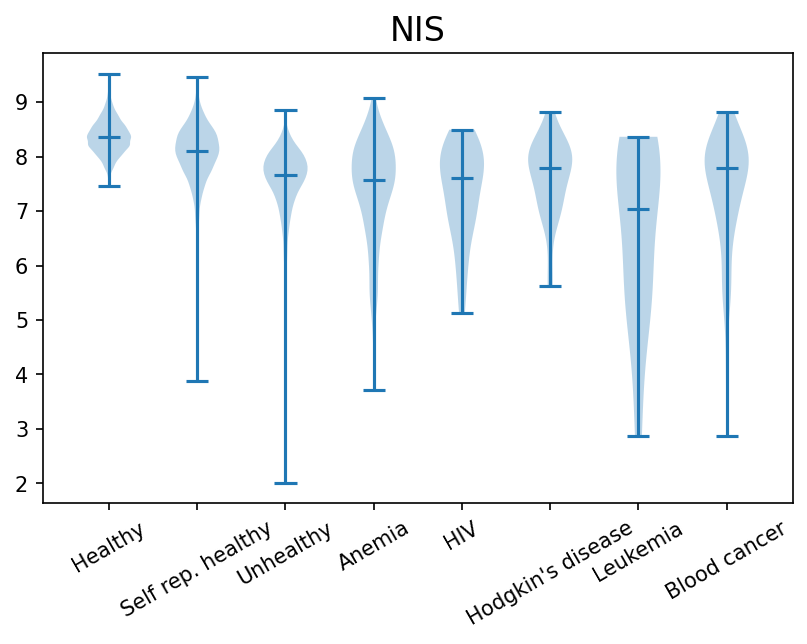

In [37]:
fig = plt.figure(figsize=(5,3), dpi=150)

ax = fig.add_axes([0,0,1,1])
bp = ax.violinplot(vals
                   #,showmeans=True
                   ,showmedians=True
                  )

set_axis_style(ax, names,'NIS')

plt.show()

The total number of samples (n) is:

In [38]:
np.sum(~np.isnan(dfN['Score']))

13081

### Anova test

In [39]:
from scipy.stats import f_oneway

In [40]:
dfN.dropna(subset=['Score'], inplace=True)

In [41]:
np.unique(dfN["DISEASE"])

array(['Anemia', 'Blood cancer', 'HIV', 'Healthy', "Hodgkin's disease",
       'Leukemia'], dtype=object)

In [42]:
healthy_scores = dfN[dfN['Colors'] == 'green']['Score']
unhealthy_scores = dfN[dfN['Colors'] != 'green']['Score']
self_healthy = dfN[dfN['DISEASE']=='Healthy']['Score'].values.tolist()
anemia_scores = dfN[dfN['DISEASE'] == 'Anemia']['Score']
hiv_scores = dfN[dfN['DISEASE'] == 'HIV']['Score']
hodgkins_scores = dfN[dfN['DISEASE'] == "Hodgkin's disease"]['Score']
leukemia_scores = dfN[dfN['DISEASE'] == 'Leukemia']['Score']
blood_cancer_scores = dfN[dfN['DISEASE'] == 'Blood cancer']['Score']

# Conducting the ANOVA test
f_stat, p_value = f_oneway(healthy_scores, unhealthy_scores, anemia_scores, hiv_scores, hodgkins_scores, leukemia_scores, blood_cancer_scores)

# Checking if the result is statistically significant
alpha = 0.05  # significance level
if p_value < alpha:
    print(f"The difference between 'Healthy' and the other conditions is statistically significant. p-value = {p_value:.4f}")
else:
    print(f"The difference between 'Healthy' and the other conditions is not statistically significant. p-value = {p_value:.4f}")

# Conducting the ANOVA test
f_stat, p_value = f_oneway(self_healthy, unhealthy_scores, anemia_scores, hiv_scores, hodgkins_scores, leukemia_scores, blood_cancer_scores)

# Checking if the result is statistically significant
alpha = 0.05  # significance level
if p_value < alpha:
    print(f"The difference between 'Healthy' and the other conditions is statistically significant. p-value = {p_value:.4f}")
else:
    print(f"The difference between 'Healthy' and the other conditions is not statistically significant. p-value = {p_value:.4f}")

The difference between 'Healthy' and the other conditions is statistically significant. p-value = 0.0000
The difference between 'Healthy' and the other conditions is statistically significant. p-value = 0.0000


### Pairwise Anova

In [43]:
diseases = ['Unhealthy', 'Anemia', 'HIV', "Hodgkin's disease", 'Leukemia', 'Blood cancer']

for disease in diseases:

    if disease == "Unhealthy" :
        disease_scores = dfN[dfN['Colors'] != 'green']['Score']

    else :
        disease_scores = dfN[dfN['DISEASE'] == disease]['Score']
    
    # Get sample sizes
    n_healthy = len(healthy_scores)
    n_disease = len(disease_scores)
    
    # Conducting the one-way ANOVA
    f_stat, p_value = f_oneway(healthy_scores, disease_scores)
    
    # Checking if the result is statistically significant
    alpha = 0.05  # significance level
    if p_value < alpha:
        print(f"The difference between 'Healthy' (n={n_healthy}) and '{disease}' (n={n_disease}) is statistically significant. p-value = {p_value:.3e} with F = {f_stat:.2f}.")
    else:
        print(f"The difference between 'Healthy' (n={n_healthy}) and '{disease}' (n={n_disease}) is not statistically significant. p-value = {p_value:.3e} with F = {f_stat:.2f}.")

The difference between 'Healthy' (n=7007) and 'Unhealthy' (n=6074) is statistically significant. p-value = 0.000e+00 with F = 8491.02.
The difference between 'Healthy' (n=7007) and 'Anemia' (n=980) is statistically significant. p-value = 0.000e+00 with F = 3924.46.
The difference between 'Healthy' (n=7007) and 'HIV' (n=62) is statistically significant. p-value = 8.745e-124 with F = 582.74.
The difference between 'Healthy' (n=7007) and 'Hodgkin's disease' (n=37) is statistically significant. p-value = 9.125e-44 with F = 195.15.
The difference between 'Healthy' (n=7007) and 'Leukemia' (n=18) is statistically significant. p-value = 5.461e-101 with F = 470.26.
The difference between 'Healthy' (n=7007) and 'Blood cancer' (n=8) is statistically significant. p-value = 8.304e-10 with F = 37.79.


**The difference between the means is statistically significant for all conditions except for 'Blood Cancer', given the low number of cases for this condition.**

In [44]:
for disease in diseases:

    if disease == "Unhealthy" :
        disease_scores = dfN[dfN['Colors'] != 'green']['Score']

    else :
        disease_scores = dfN[dfN['DISEASE'] == disease]['Score']
    
    # Get sample sizes
    n_healthy = len(self_healthy)
    n_disease = len(disease_scores)
    
    # Conducting the one-way ANOVA
    f_stat, p_value = f_oneway(self_healthy, disease_scores)
    
    # Checking if the result is statistically significant
    alpha = 0.05  # significance level
    if p_value < alpha:
        print(f"The difference between 'Self rep. Healthy' (n={n_healthy}) and '{disease}' (n={n_disease}) is statistically significant. p-value = {p_value:.3e} with F = {f_stat:.2f}.")
    else:
        print(f"The difference between 'Self rep. Healthy' (n={n_healthy}) and '{disease}' (n={n_disease}) is not statistically significant. p-value = {p_value:.3e} with F = {f_stat:.2f}.")

The difference between 'Self rep. Healthy' (n=11976) and 'Unhealthy' (n=6074) is statistically significant. p-value = 0.000e+00 with F = 2581.85.
The difference between 'Self rep. Healthy' (n=11976) and 'Anemia' (n=980) is statistically significant. p-value = 1.274e-191 with F = 901.93.
The difference between 'Self rep. Healthy' (n=11976) and 'HIV' (n=62) is statistically significant. p-value = 2.695e-19 with F = 80.92.
The difference between 'Self rep. Healthy' (n=11976) and 'Hodgkin's disease' (n=37) is statistically significant. p-value = 2.287e-05 with F = 17.95.
The difference between 'Self rep. Healthy' (n=11976) and 'Leukemia' (n=18) is statistically significant. p-value = 7.016e-22 with F = 92.78.
The difference between 'Self rep. Healthy' (n=11976) and 'Blood cancer' (n=8) is not statistically significant. p-value = 8.029e-02 with F = 3.06.


## NCCIS

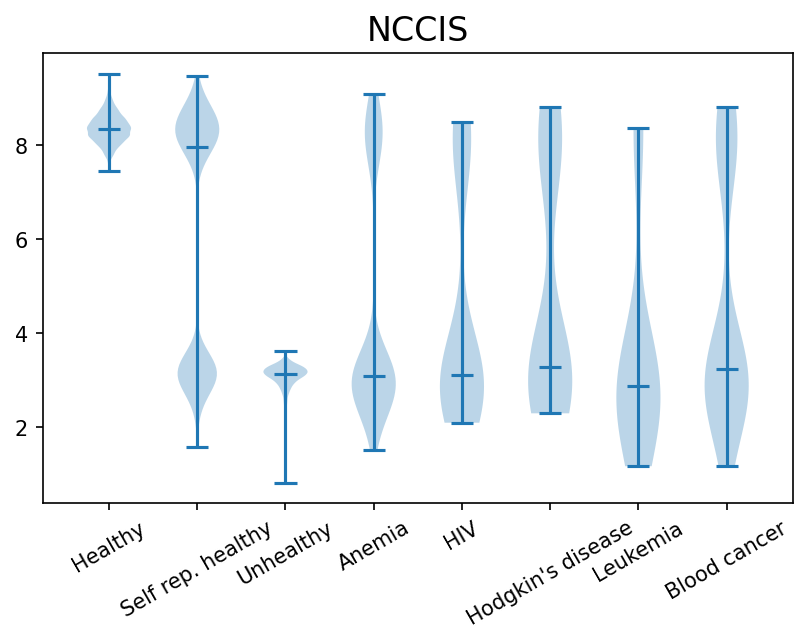

In [45]:
vals2 = [
    dfAll[dfAll["Colors"]=='green']['NCCIS'].values.tolist(),
    dfN[dfN['DISEASE']=='Healthy']['NCCIS'].values.tolist(),
    dfAll[dfAll["Colors"]!='green']['NCCIS'].values.tolist(),
    dfN[dfN['DISEASE']=='Anemia']['NCCIS'].values.tolist(),
    dfN[dfN['DISEASE']=='HIV']['NCCIS'].values.tolist(),
    dfN[dfN['DISEASE']=="Hodgkin's disease"]['NCCIS'].values.tolist(),
    dfN[dfN['DISEASE']=="Leukemia"]['NCCIS'].values.tolist(),
    dfN[np.logical_or(
            np.logical_or(
                dfN['DISEASE']=='Blood cancer', dfN['DISEASE']=="Hodgkin's disease"
                    ), 
            dfN['DISEASE']=="Leukemia")
        ]['NCCIS'].values.tolist()
]

fig = plt.figure(figsize=(5,3), dpi=150)

ax = fig.add_axes([0,0,1,1])
bp = ax.violinplot(vals2
                   #,showmeans=True
                   ,showmedians=True
                  )

set_axis_style(ax, names,'NCCIS')

plt.show()

### Pairwise Anova

In [46]:
healthy_scores = dfN[dfN['Colors'] == 'green']['NCCIS']
self_healthy = dfN[dfN['DISEASE']=='Healthy']['NCCIS'].values.tolist()

In [47]:
for disease in diseases:

    if disease == "Unhealthy" :
        disease_scores = dfN[dfN['Colors'] != 'green']['NCCIS']

    else :
        disease_scores = dfN[dfN['DISEASE'] == disease]['NCCIS']
    
    # Get sample sizes
    n_healthy = len(healthy_scores)
    n_disease = len(disease_scores)
    
    # Conducting the one-way ANOVA
    f_stat, p_value = f_oneway(healthy_scores, disease_scores)
    
    # Checking if the result is statistically significant
    alpha = 0.05  # significance level
    if p_value < alpha:
        print(f"The difference between 'Healthy' (n={n_healthy}) and '{disease}' (n={n_disease}) is statistically significant. p-value = {p_value:.3e} with F = {f_stat:.2f}.")
    else:
        print(f"The difference between 'Healthy' (n={n_healthy}) and '{disease}' (n={n_disease}) is not statistically significant. p-value = {p_value:.3e} with F = {f_stat:.2f}.")

The difference between 'Healthy' (n=7007) and 'Unhealthy' (n=6074) is statistically significant. p-value = 0.000e+00 with F = 999606.16.
The difference between 'Healthy' (n=7007) and 'Anemia' (n=980) is statistically significant. p-value = 0.000e+00 with F = 15813.15.
The difference between 'Healthy' (n=7007) and 'HIV' (n=62) is statistically significant. p-value = 0.000e+00 with F = 6238.98.
The difference between 'Healthy' (n=7007) and 'Hodgkin's disease' (n=37) is statistically significant. p-value = 0.000e+00 with F = 3409.57.
The difference between 'Healthy' (n=7007) and 'Leukemia' (n=18) is statistically significant. p-value = 0.000e+00 with F = 3571.64.
The difference between 'Healthy' (n=7007) and 'Blood cancer' (n=8) is statistically significant. p-value = 1.254e-122 with F = 577.17.


**All values are statistically significant.**

In [48]:
for disease in diseases:

    if disease == "Unhealthy" :
        disease_scores = dfN[dfN['Colors'] != 'green']['NCCIS']

    else :
        disease_scores = dfN[dfN['DISEASE'] == disease]['NCCIS']
    
    # Get sample sizes
    n_healthy = len(self_healthy)
    n_disease = len(disease_scores)
    
    # Conducting the one-way ANOVA
    f_stat, p_value = f_oneway(self_healthy, disease_scores)
    
    # Checking if the result is statistically significant
    alpha = 0.05  # significance level
    if p_value < alpha:
        print(f"The difference between 'Healthy' (n={n_healthy}) and '{disease}' (n={n_disease}) is statistically significant. p-value = {p_value:.3e} with F = {f_stat:.2f}.")
    else:
        print(f"The difference between 'Healthy' (n={n_healthy}) and '{disease}' (n={n_disease}) is not statistically significant. p-value = {p_value:.3e} with F = {f_stat:.2f}.")

The difference between 'Healthy' (n=11976) and 'Unhealthy' (n=6074) is statistically significant. p-value = 0.000e+00 with F = 7704.66.
The difference between 'Healthy' (n=11976) and 'Anemia' (n=980) is statistically significant. p-value = 1.740e-76 with F = 347.18.
The difference between 'Healthy' (n=11976) and 'HIV' (n=62) is statistically significant. p-value = 8.844e-07 with F = 24.19.
The difference between 'Healthy' (n=11976) and 'Hodgkin's disease' (n=37) is statistically significant. p-value = 4.284e-03 with F = 8.16.
The difference between 'Healthy' (n=11976) and 'Leukemia' (n=18) is statistically significant. p-value = 5.554e-05 with F = 16.26.
The difference between 'Healthy' (n=11976) and 'Blood cancer' (n=8) is not statistically significant. p-value = 5.739e-01 with F = 0.32.


### NIS vs NCCIS Analytic Comparison

### Function to Create Test Spaces

In [49]:
def testSpace(nAnalytes, nCategories=2):
    # First, we generate a list of dummy analytes.
    analytes = testAnalytes(nAnalytes)
    keys = analytes.copy()
    ws= {}
    rs = {}
    sd = {}

    mns = {}
    
    for a in keys :
        for c in range(nCategories) :
            ws[a] = 1
            rs[a,c] = (0,1)
            sd[a,c] = 0.25
            mns[a,c] = 0.5
            
    return analytes,keys,nAnalytes,nCategories,ws,rs,sd, mns

In [50]:
def testAnalytes(n):
    ana = []
    for i in range(1,n+1):
        ana.append(str(i))
        
    return ana

In [51]:
def testAna(space, dsp, lwr = False, cls = 0):
    ana = {}
    
    ks = space.keys
    
    #We get the upper range.
    for k in ks :
        hr = space.ranges[k, cls][1]
        vl = hr*dsp
        ana[k] = vl
        
    return ana
        

### Comparison Function

In [52]:
def expFunc(nAnalytes, dsp, nCat = 2, cat = 0):

    cat += 1
    
    space = Space(prebuilt = testSpace(nAnalytes, nCat))
    
    ana = testAna(space, dsp, cls = cat)

    
    p = Patient(
        ana, # The analytes.
            cat, # Its class.
            space # The declared space.
        )
    
    return p.score()

# Comparison Plot

In [53]:
res = np.zeros((100,100))

for r in range(1,101) : # Number of analytes
    for c in range(100): # Displacement (from 0 to 3xMax Value)
        vl = c*2/100
        
        v  = expFunc(r, vl)
            
        res[r-1,c] = v

In [54]:
f = lambda x: (1/50)*x-1
f = np.vectorize(f)

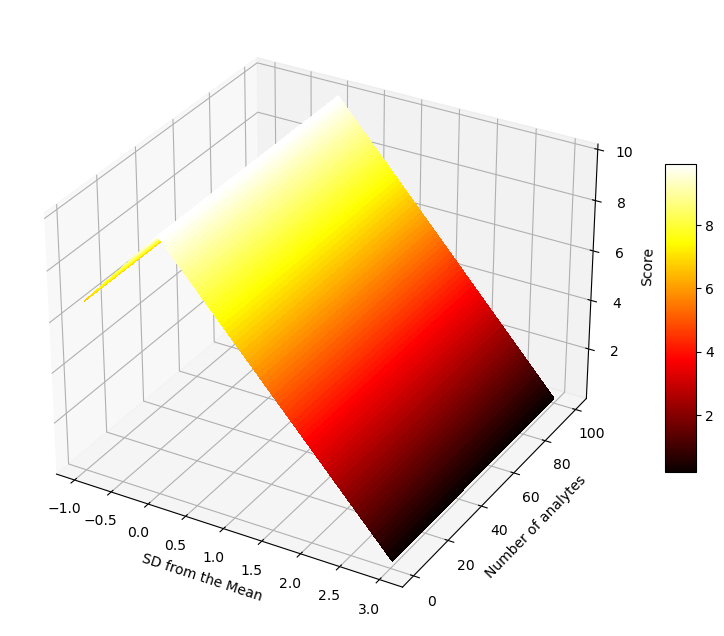

In [55]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

X = f(np.arange(1, 101)*2)  # Assuming you have defined the f function somewhere
Y = np.arange(1, 101)
X, Y = np.meshgrid(X, Y)

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X, Y, res, rstride=1, cstride=1, cmap='hot', linewidth=0, antialiased=False)

ax.set_ylabel('Number of analytes')
ax.set_xlabel('SD from the Mean')
ax.set_zlabel('Score')

fig.colorbar(surf, shrink=0.5, aspect=10)
plt.show()


## NCCIS

In [56]:
NCCIS().apply

<bound method NCCIS.apply of <Score.Score.NCCIS object at 0x000001D4FC8E2A70>>

In [58]:
def expFunc(nAnalytes, dsp, nCat = 2, cat = 0):

    cat += 1
    
    space = Space(prebuilt = testSpace(nAnalytes, nCat))
    
    ana = testAna(space, dsp, cls = cat)

    
    p = Patient(
        ana, # The analytes.
            cat, # Its class.
            space # The declared space.
        )

    out =  NCCIS().apply(p.score(), p.color)
    
    return out

In [59]:
res = np.zeros((100,100))

for r in range(1,101) : # Number of analytes
    for c in range(100): # Displacement (from 0 to 3xMax Value)
        vl = c*2/100
        
        v  = expFunc(r, vl)
            
        res[r-1,c] = v

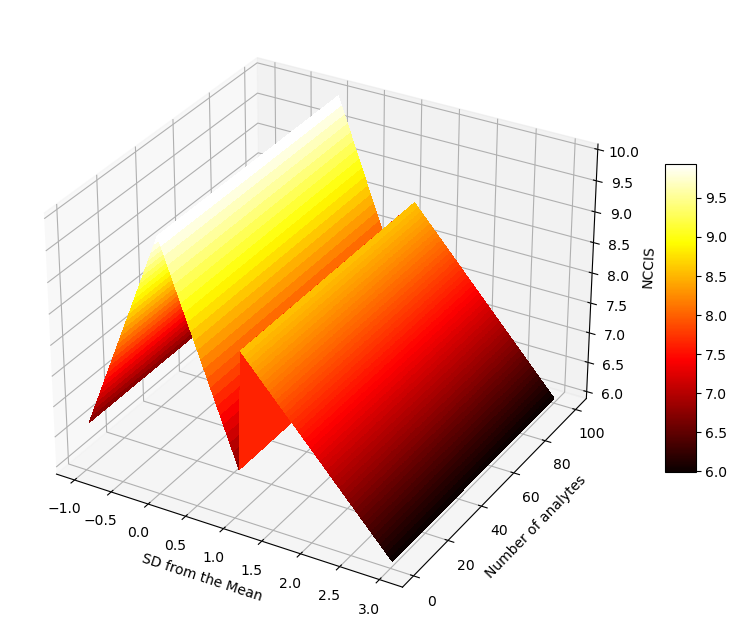

In [60]:
import matplotlib.pyplot as plt
import numpy as np

X = f(np.arange(1, 101)*2)  # Assuming you have defined the f function somewhere
Y = np.arange(1, 101)
X, Y = np.meshgrid(X, Y)

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X, Y, res, rstride=1, cstride=1, cmap='hot', linewidth=0, antialiased=False)

ax.set_ylabel('Number of analytes')
ax.set_xlabel('SD from the Mean')
ax.set_zlabel('NCCIS')

fig.colorbar(surf, shrink=0.5, aspect=10)
plt.show()

In [61]:
dfN["Colors"]=="green"

0         True
1        False
2         True
3        False
4        False
         ...  
13078     True
13079     True
13080     True
13081    False
13082    False
Name: Colors, Length: 13081, dtype: bool